In [1]:
%matplotlib inline
import os
import re
import gc
import random
import numpy
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
from datetime import datetime
from progressbar import ProgressBar

In [2]:
with open("logs/libvirtd.log", "r") as log:
    log_lines = [line.strip() for line in log.readlines()]
    
print(random.choice(log_lines))

2017-03-07 02:39:33.964+0000: 30192: info : virObjectRef:296 : OBJECT_REF: obj=0x7f8d1c000fb0


In [221]:
class LogMsg:
    msg_type_normal_regex = {
        # info
        'virObjectRef': [
            re.compile(r'^virObjectRef:[0-9]+:OBJECT_REF:obj=0x[0-9a-f]+$'),
        ],
        'virObjectUnref': [
            re.compile(r'^virObjectUnref:[0-9]+:OBJECT_UNREF:obj=0x[0-9a-f]+$'),
            re.compile(r'^virObjectUnref:[0-9]+:OBJECT_DISPOSE:obj=0x[0-9a-f]+$'),
        ],
        'virObjectNew': [
            re.compile(r'^virObjectNew:[0-9]+:OBJECT_NEW:obj=0x[0-9a-f]+ classname=(vir|qemu)[A-Za-z]+$'),
        ],
        'qemuMonitorIOProcess': [
            re.compile(r'^qemuMonitorIOProcess:[0-9]+:QEMU_MONITOR_IO_PROCESS:mon=0x[0-9a-f]+ buf=.+(\n)*len=[0-9]+$'),
            re.compile(r'^qemuMonitorIOProcess:[0-9]+:QEMU_MONITOR_IO_PROCESS:mon=0x[0-9a-f]+ buf=(.+\n)+len=[0-9]+$'),
        ],
        'qemuMonitorIOWrite': [
            re.compile(r'^qemuMonitorIOWrite:[0-9]+:QEMU_MONITOR_IO_WRITE:mon=0x[0-9a-f]+ buf=.+\nlen=[0-9]+ ret=[0-9]+ errno=[0-9]+$'),
            re.compile(r'^qemuMonitorIOWrite:[0-9]+:QEMU_MONITOR_IO_SEND_FD:mon=0x[0-9a-f]+ fd=[0-9]+ ret=[0-9]+ errno=[0-9]+'),
        ],
        'qemuMonitorSend': [
            re.compile(r'^qemuMonitorSend:[0-9]+:QEMU_MONITOR_SEND_MSG:mon=0x[0-9a-f]+ msg={.+}\nfd=[\-0-9]'),
        ],
        'virFirewallApplyRule': [
            re.compile(r"^virFirewallApplyRule:[0-9]+:Applying rule '.*(.*\n)*'$"),
            re.compile(r"^virFirewallApplyRule:[0-9]+:Invoking query 0x[0-9a-f]+ with '.*(.*\n)*'$"),
        ],
        'virDBusCall': [
            re.compile(r"^virDBusCall:[0-9]+:DBUS_METHOD_CALL:'[a-zA-Z0-9\.]+' on '[a-zA-Z0-9/]+' at '[a-zA-Z0-9\.]+'$"),
            re.compile(r"^virDBusCall:[0-9]+:DBUS_METHOD_REPLY:'[a-zA-Z0-9\.]+' on '[a-zA-Z0-9/]+' at '[a-zA-Z0-9\.]+'$"),
        ],
        'virFirewallApplyGroup': [
            re.compile(r"^virFirewallApplyGroup:[0-9]+:Starting transaction for firewall=0x[0-9a-f]+ group=0x[0-9a-f]+ flags=[0-1]$"),
        ],
        'virSecuritySELinuxSetFileconHelper': [
            re.compile(r"^virSecuritySELinuxSetFileconHelper:[0-9]+:Setting SELinux context on '[a-zA-Z0-9\.\-/]+' to '[a-z_:0-9,]+'$"),
        ],
        'virSecurityDACSetOwnershipInternal': [
            re.compile(r"^virSecurityDACSetOwnershipInternal:[0-9]+:Setting DAC user and group on '[a-zA-Z0-9\.\-/]+' to '[:0-9]+'$"),
        ],
        'virNetDevProbeVnetHdr': [
            re.compile(r'^virNetDevProbeVnetHdr:[0-9]+:Enabling IFF_VNET_HDR$'),
        ],
        'qemuMonitorClose': [
            re.compile(r'^qemuMonitorClose:[0-9]+:QEMU_MONITOR_CLOSE:mon=0x[0-9a-f]+ refs=[0-9]+$'),
        ],
        'qemuMonitorOpenInternal': [
            re.compile(r'^qemuMonitorOpenInternal:[0-9]+:QEMU_MONITOR_NEW:mon=0x[0-9a-f]+ refs=[0-9]+ fd=[0-9]+$'),
        ],
        # debug
        'virAccessManagerCheckConnect': [
            re.compile(r'^virAccessManagerCheckConnect:[0-9]+:manager=0x[0-9a-f]+\(name=(stack|none)\) driver=QEMU perm=[0-9]+$'),
        ],
        'virAccessManagerCheckDomain': [
            re.compile(r'^virAccessManagerCheckDomain:[0-9]+:manager=0x[0-9a-f]+\(name=(stack|none)\) driver=QEMU domain=0x[0-9a-f]+ perm=[0-9]+$'),
        ],
        'virThreadJobClear': [
            re.compile(r'^virThreadJobClear:[0-9]+:Thread [0-9]+ \(virNetServerHandleJob\) finished job [a-zA-Z0-9]+ with ret=0$'),
        ],
        'virThreadJobSet': [
            re.compile(r'^virThreadJobSet:[0-9]+:Thread [0-9]+ \(virNetServerHandleJob\) is now running job [a-zA-Z0-9]+$'),
        ],
        'qemuDomainObjBeginJobInternal': [
            re.compile(r'^qemuDomainObjBeginJobInternal:[0-9]+:Starting job:query \(vm=0x[0-9a-f]+ name=[a-zA-Z0-9]+, current job=(none|query) async=none\)$'),
            re.compile(r'^qemuDomainObjBeginJobInternal:[0-9]+:Started job:query \(async=none vm=0x[0-9a-f]+ name=[a-zA-Z0-9]+\)$'),
            re.compile(r'^qemuDomainObjBeginJobInternal:[0-9]+:Waiting for job \(vm=0x[0-9a-f]+ name=[a-zA-Z0-9]+\)$'),
            re.compile(r'^qemuDomainObjBeginJobInternal:[0-9]+:Starting job:migration operation \(vm=0x[0-9a-f]+ name=[a-zA-Z0-9]+, current job=(none|query) async=none\)$'),
            re.compile(r'^qemuDomainObjBeginJobInternal:[0-9]+:Started job:migration operation \(async=none vm=0x[0-9a-f]+ name=[a-zA-Z0-9]+\)$'),
        ],
        'virDomainDispose': [
            re.compile(r'^virDomainDispose:[0-9]+:release domain 0x[0-9a-f]+ [a-zA-Z0-9]+ [a-f0-9\-]+$'),
        ],
        'virFileClose': [
            re.compile(r'^virFileClose:[0-9]+:Closed fd [1-9][0-9]*\n{0,1}\'{0,1}$'),
        ],
        'qemuDomainObjEndJob': [
            re.compile(r'^qemuDomainObjEndJob:[0-9]+:Stopping job:query \(async=none vm=0x[0-9a-f]+ name=[a-zA-Z0-9]+\)$'),
            re.compile(r'^qemuDomainObjEndJob:[0-9]+:Stopping job:migration operation \(async=none vm=0x[0-9a-f]+ name=[a-zA-Z0-9]+\)$'),
        ],
        'virCgroupGetValueStr': [
            re.compile(r'^virCgroupGetValueStr:[0-9]+:Get value [/\\a-zA-Z0-9,\-\.]+$'),
        ],
        'qemuDomainObjExitMonitorInternal': [
            re.compile(r'^qemuDomainObjExitMonitorInternal:[0-9]+:Exited monitor \(mon=0x[0-9a-f]+ vm=0x[0-9a-f]+ name=[a-zA-Z0-9]+\)$'),
        ],
        'qemuDomainObjEnterMonitorInternal': [
            re.compile(r'^qemuDomainObjEnterMonitorInternal:[0-9]+:Entering monitor \(mon=0x[0-9a-f]+ vm=0x[0-9a-f]+ name=[a-zA-Z0-9]+\)$'),
        ],
        'qemuMonitorBlockStatsUpdateCapacity': [
            re.compile(r'^qemuMonitorBlockStatsUpdateCapacity:[0-9]+:stats=0x[0-9a-f]+, backing=0$'),
            re.compile(r'^qemuMonitorBlockStatsUpdateCapacity:[0-9]+:mon:0x[0-9a-f]+ vm:0x[0-9a-f]+ json:1 fd:[1-9][0-9]*$'),
        ],
        'qemuMonitorGetAllBlockStatsInfo': [
            re.compile(r'^qemuMonitorGetAllBlockStatsInfo:[0-9]+:ret_stats=0x[0-9a-f]+, backing=0$'),
            re.compile(r'^qemuMonitorGetAllBlockStatsInfo:[0-9]+:mon:0x[0-9a-f]+ vm:0x[0-9a-f]+ json:1 fd:[1-9][0-9]*$'),
        ],
        'virConnectSupportsFeature': [
            re.compile(r'^virConnectSupportsFeature:[0-9]+:conn=0x[0-9a-f]+, feature=[0-9]+$'),
        ],
        'qemuMonitorGetBlockIoThrottle': [
            re.compile(r'^qemuMonitorGetBlockIoThrottle:[0-9]+:device=0x[0-9a-f]+, reply=0x[0-9a-f]+$'),
            re.compile(r'^qemuMonitorGetBlockIoThrottle:[0-9]+:mon:0x[0-9a-f]+ vm:0x[0-9a-f]+ json:1 fd:[1-9][0-9]*$'),
        ],
        'qemuGetProcessInfo': [
            re.compile(r'^qemuGetProcessInfo:[0-9]+:Got status for [0-9]+/[0-9]+ user=[0-9]+ sys=[0-9]+ cpu=[0-9]+ rss=[0-9]+$'),
        ],
        'virDomainFree': [
            re.compile(r'^virDomainFree:[0-9]+:dom=0x[0-9a-f]+, \(VM:name=[a-zA-Z0-9]+, uuid=[a-f0-9\-]+\)$'),
        ],
        'virDomainGetBlockIoTune': [
            re.compile(r'^virDomainGetBlockIoTune:[0-9]+:dom=0x[0-9a-f]+, \(VM:name=[a-zA-Z0-9]+, uuid=[a-f0-9\-]+\), disk=sda, params=(\(nil\)|0x[0-9a-f]+), nparams=[0-9]+, flags=[0-9]+$'),
        ],
        'virDomainGetMetadata': [
            re.compile(r'^virDomainGetMetadata:[0-9]+:dom=0x[0-9a-f]+, \(VM:name=[a-zA-Z0-9]+, uuid=[a-f0-9\-]+\), type=[0-9]+, uri=\'http://[a-z0-9\./]+\', flags=[0-9]+$'),
        ],
        'virNodeGetMemoryStats': [
            re.compile(r'^virNodeGetMemoryStats:[0-9]+:conn=0x[0-9a-f]+, cellNum=0, params=(\(nil\)|0x[0-9a-f]+), nparams=[0-9]+, flags=[0-9]+$'),
        ],
        'virConnectGetAllDomainStats': [
            re.compile(r'^virConnectGetAllDomainStats:[0-9]+:conn=0x[0-9a-f]+, stats=0x0, retStats=0x[0-9a-f]+, flags=0x0$'),
        ],
        'virDomainGetControlInfo': [
            re.compile(r'^virDomainGetControlInfo:[0-9]+:dom=0x[0-9a-f]+, \(VM:name=[a-zA-Z0-9]+, uuid=[a-f0-9\-]+\), info=0x[0-9a-f]+, flags=[0-9]+$'),
        ],
        'virAccessManagerCheckNodeDevice': [
            re.compile(r'^virAccessManagerCheckNodeDevice:[0-9]+:manager=0x[0-9a-f]+\(name=(none|stack)\) driver=QEMU nodedev=0x[0-9a-f]+ perm=0$'),
        ],
        'virNodeDeviceDispose': [
            re.compile(r'^virNodeDeviceDispose:[0-9]+:release dev 0x[0-9a-f]+ [a-zA-Z0-9_]+$'),
        ],
        'virCgroupDetect': [
            re.compile(r'^virCgroupDetect:[0-9]+:group=0x[0-9a-f]+ controllers=(-1|[0-9]+) path= parent=\(nil\)$'),
            re.compile(r'^virCgroupDetect:[0-9]+:Auto-detecting controllers$'),
            re.compile(r'^virCgroupDetect:[0-9]+:Controller \'(name=){0,1}[a-z_]+\' present=yes$'),
            re.compile(r'^virCgroupDetect:[0-9]+:Detected mount/mapping (0:cpu|1:cpuacct) at [/a-z,]+ in [0-9a-zA-Z\.\\/\-]+ for pid [0-9]+$'),
        ],
        'virAccessManagerCheckNodeDevice': [
            re.compile(r'^virAccessManagerCheckNodeDevice:[0-9]+:manager=0x[0-9a-f]+\(name=(stack|none)\) driver=QEMU nodedev=0x[0-9a-f]+ perm=[0-1]$'),
        ],
        'virNodeDeviceLookupByName': [
            re.compile(r'^virNodeDeviceLookupByName:[0-9]+:conn=0x[0-9a-f]+, name=[a-zA-Z0-9_]+$'),
        ],
        'virCgroupMakeGroup': [
            re.compile(r'^virCgroupMakeGroup:[0-9]+:Make group [/,a-zA-Z0-9\.\\\-_]+$'),
            re.compile(r'^virCgroupMakeGroup:[0-9]+:Make controller [/,a-zA-Z0-9\.\\\-_]+$'),
            re.compile(r'^virCgroupMakeGroup:[0-9]+:Done making controllers for group$'),
        ],
        'virCommandRunAsync': [
            re.compile(r'^virCommandRunAsync:[0-9]+:About to run .+$'),
            re.compile(r'^virCommandRunAsync:[0-9]+:Command result 0, with PID [0-9]+$'),
        ],
        'virCommandRun': [
            re.compile(r'^virCommandRun:[0-9]+:Result (exit ){0,1}status 0, stdout:\'.*\' stderr:\'.*(\'){0,1}$', re.DOTALL),
        ],
        'virNodeDeviceGetXMLDesc': [
            re.compile(r'^virNodeDeviceGetXMLDesc:[0-9]+:dev=0x[0-9a-f]+, conn=0x[0-9a-f]+, flags=[0-9]+$'),
        ],
        'virDomainGetInfo': [
            re.compile(r'^virDomainGetInfo:[0-9]+:dom=0x[0-9a-f]+, \(VM:name=[a-zA-Z0-9]+, uuid=[a-f0-9\-]+\), info=0x[0-9a-f]+$'),
        ],
        'virNodeGetCPUMap': [
            re.compile(r'^virNodeGetCPUMap:[0-9]+:conn=0x[0-9a-f]+, cpumap=\(nil\), online=\(nil\), flags=0$'),
        ],
    }

    error_regex = [
        re.compile(r"error", re.IGNORECASE),
        re.compile(r"not ", re.IGNORECASE),
        re.compile(r"doesn't", re.IGNORECASE),
        re.compile(r"\"[a-zA-Z_]*invalid[a-zA-Z_]*\":[-1-9]+", re.IGNORECASE),
        re.compile(r"\"[a-zA-Z_]*invalid[a-zA-Z_]*\":true", re.IGNORECASE),
        re.compile(r"invalid", re.IGNORECASE),
        re.compile(r"\"[a-zA-Z_]*failed[a-zA-Z_]*\":[-1-9]+", re.IGNORECASE),
        re.compile(r"\"[a-zA-Z_]*failed[a-zA-Z_]*\":true", re.IGNORECASE),
        re.compile(r"fail", re.IGNORECASE),
        re.compile(r"fatal", re.IGNORECASE),
    ]

    def __init__(self):
        self.msg = None
        self.type = None
        self.suspicious_level = 'Mismatch normal'
        self.error_contains = False
        self.error_pos = []

    def parse(self, line):
        self.msg = line
        self.type = line.split(':')[0]
        if self.type not in LogMsg.msg_type_normal_regex:
            self.suspicious_level = 'Unknown message type'
        else:
            for regex in LogMsg.msg_type_normal_regex[self.type]:
                if regex.match(self.msg):
                    self.suspicious_level = 'Good'

        for error_regex in LogMsg.error_regex:
            if error_regex.search(self.msg):
                self.error_contains = True
                self.error_pos.extend([match for match in error_regex.finditer(self.msg)])
        return self

    def to_error_str(self):
        pos = 0
        result = ''
        for match in sorted(self.error_pos, key=lambda x: x.start()):
            if pos >= match.end():
                continue
            if pos < match.start():
                result += self.msg[pos:match.start()]
                pos = match.start()
            result += TextColor.BOLD + TextColor.RED + self.msg[pos:match.end()] + TextColor.END
            pos = match.end()
        if pos < len(self.msg):
            result += self.msg[pos:]
        return result.replace('\n', '\\n')

    def __str__(self):
        return self.msg

In [4]:
class CommonLogItem:
    def __init__(self):
        self.line_index = None
        self.date = None
        self.thread = None
        self.level = None
        self.msg = None

    def parse(self, line, ind):
        # Set line index
        self.line_index = ind
        # Parse datetime
        try:
            self.date = datetime.strptime(line[:28], "%Y-%m-%d %H:%M:%S.%f%z")
            line = line[29:]
        except:
            raise Exception("Cannot parse datetime in {}".format(line))
        # Split log line
        splits = [item.strip() for item in line.split(':')]
        # Parse log code
        if self.date and len(splits) > 1:
            if re.match(r'[0-9]+', splits[0]):
                self.thread = splits[0]
                splits = splits[1:]
            else:
                raise Exception("Cannot parse thread in {}".format(splits[0]))
        if self.thread and len(splits) > 1:
            if splits[0] in ['debug', 'info']:
                self.level = splits[0]
                splits = splits[1:]
            else:
                raise Exception("Cannot parse log type in {}".format(splits[0]))
        self.msg = LogMsg().parse(':'.join(splits))
        return self

In [5]:
class LogParser:
    def __init__(self):
        pass

    def parse(self, line, ind):
        return CommonLogItem().parse(line, ind)

In [6]:
process_lines = []
bar = ProgressBar(max_value=len(log_lines))
for i, line in enumerate(log_lines):
    try:
        date = datetime.strptime(line[:28], "%Y-%m-%d %H:%M:%S.%f%z")
        process_lines.append((line, i + 1))
    except:
        process_lines[-1] = (process_lines[-1][0] + '\n' + line, process_lines[-1][1])
    bar.update(i)
bar.finish()
del log_lines

 99% (1511752 of 1513373) |############### | Elapsed Time: 0:00:45 ETA: 0:00:00


In [222]:
parser = LogParser()
bar = ProgressBar(max_value=len(process_lines))
logs = []
for i, (line, ind) in enumerate(process_lines):
    logs.append(parser.parse(line, ind))
    bar.update(i)
bar.finish()
# del process_lines

 99% (1450915 of 1451423) |############### | Elapsed Time: 0:02:12 ETA: 0:00:00


In [223]:
df = pd.DataFrame()
df['line_index'] = [log.line_index for log in logs]
df['date'] = [log.date for log in logs]
df['thread'] = [log.thread for log in logs]
df['level'] = [log.level for log in logs]
df['msg'] = [log.msg for log in logs]
df['msg_type'] = [log.msg.type for log in logs]
df['suspicious_level'] = [log.msg.suspicious_level for log in logs]
df['error_contains'] = [log.msg.error_contains for log in logs]
del logs
df.head()

,line_index,date,thread,level,msg,msg_type,suspicious_level,error_contains
0,1,2017-03-07 01:38:18.929000+00:00,30192,info,virObjectRef:296:OBJECT_REF:obj=0x7f8d75667970,virObjectRef,Good,False
1,2,2017-03-07 01:38:18.929000+00:00,30192,info,virObjectRef:296:OBJECT_REF:obj=0x7f8d7535a390,virObjectRef,Good,False
2,3,2017-03-07 01:38:18.929000+00:00,30195,info,virObjectRef:296:OBJECT_REF:obj=0x7f8d50000cf0,virObjectRef,Good,False
3,4,2017-03-07 01:38:18.929000+00:00,30195,info,virObjectRef:296:OBJECT_REF:obj=0x7f8d50000cf0,virObjectRef,Good,False
4,5,2017-03-07 01:38:18.929000+00:00,30195,debug,virThreadJobSet:96:Thread 30195 (virNetServerH...,virThreadJobSet,Good,False


In [224]:
df[df.level == "debug"].suspicious_level.value_counts(dropna=False)

Good                    467030
Unknown message type      3346
Mismatch normal           1313
Name: suspicious_level, dtype: int64

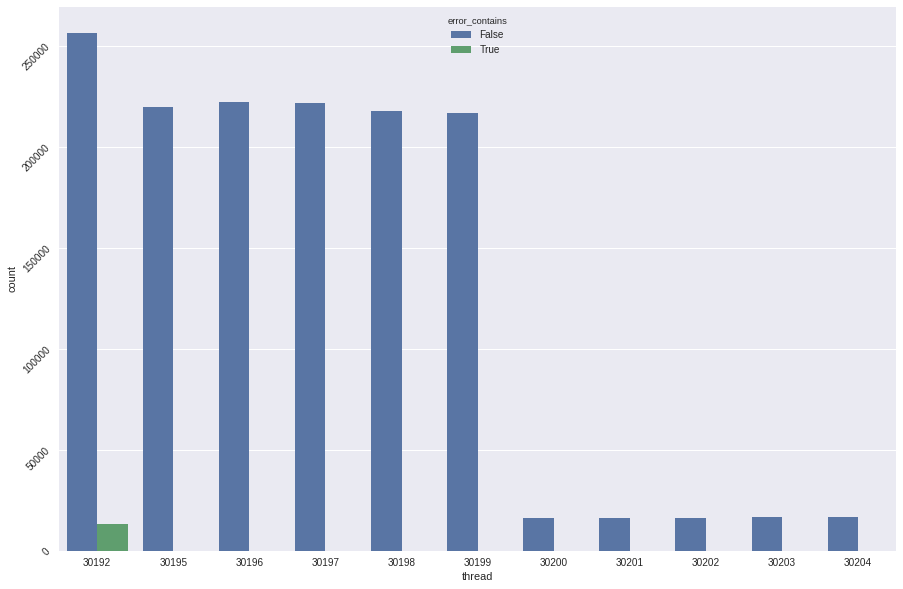

In [9]:
_, ax = pyplot.subplots(figsize=(15, 10))
g = sns.countplot(data=df[df.thread.astype(int) > 30000], x='thread', hue='error_contains', ax=ax)
for item in g.get_yticklabels():
    item.set_rotation(45)
pyplot.show()

In [225]:
df.query("level == 'debug' and suspicious_level != 'Good'").msg_type.value_counts()
# for line in df.query("type == 'debug' and msg_type == 'virFirewallApplyRule' and suspicious_level != 'Good'").msg:
#     print('\x1b[31m', repr(str(line)), '\x1b[0m')
#     break
# df.query("type == 'debug' and suspicious_level == 'Unmatch normal'").msg_type.value_counts()

virDBusMessageIterEncode                  406
virCgroupDetect                           336
virCommandRun                             264
virFileClose                              264
virFirewallApplyRuleDirect                264
virDomainGetVcpus                         165
qemuDomainObjBeginJobInternal             157
virCgroupMakeGroup                        156
virDomainPCIAddressReserveAddr            120
virCgroupSetValueStr                      118
virPCIGetDeviceAddressFromSysfsLink       108
virPCIGetVirtualFunctions                 108
virQEMUCapsCacheLookup                    101
cpuDecode                                  93
virAccessManagerCheckNetwork               90
qemuProcessLaunch                          90
virDomainPCIAddressGetNextSlot             89
qemuDomainObjEndJob                        74
ebtablesRenameTmpSubAndRootChainsQuery     60
virCgroupGetValueStr                       57
virFileMakePathHelper                      50
virTimeBackOffWait                

In [230]:
for line in df.query("level == 'debug' and suspicious_level != 'Good' and msg_type == 'virAccessManagerCheckNetwork'").msg:
    print(repr(str(line)))

'virAccessManagerCheckNetwork:264:manager=0x7f8d75345ca0(name=stack) driver=QEMU network=0x7f8d753802d0 perm=0'
'virAccessManagerCheckNetwork:264:manager=0x7f8d75345d90(name=none) driver=QEMU network=0x7f8d753802d0 perm=0'
'virAccessManagerCheckNetwork:264:manager=0x7f8d75345ca0(name=stack) driver=QEMU network=0x7f8d7537e6e0 perm=0'
'virAccessManagerCheckNetwork:264:manager=0x7f8d75345d90(name=none) driver=QEMU network=0x7f8d7537e6e0 perm=0'
'virAccessManagerCheckNetwork:264:manager=0x7f8d75345ca0(name=stack) driver=QEMU network=0x7f8d753744c0 perm=0'
'virAccessManagerCheckNetwork:264:manager=0x7f8d75345d90(name=none) driver=QEMU network=0x7f8d753744c0 perm=0'
'virAccessManagerCheckNetwork:264:manager=0x7f8d75345ca0(name=stack) driver=QEMU network=0x7f8d75380530 perm=0'
'virAccessManagerCheckNetwork:264:manager=0x7f8d75345d90(name=none) driver=QEMU network=0x7f8d75380530 perm=0'
'virAccessManagerCheckNetwork:264:manager=0x7f8d75345ca0(name=stack) driver=QEMU network=0x7f8d753778a0 perm

In [12]:
#"invalid"
#"not "
#"doesn't"
for line in df.query("suspicious_level == 'Unknown message type'").msg:
    if re.search(r"fail", str(line), re.IGNORECASE):
        print(repr(str(line)))

"udevRemoveOneDevice:1039:Failed to find device to remove that has udev name '/sys/devices/virtual/net/vnet0/queues/rx-0'"
"udevRemoveOneDevice:1039:Failed to find device to remove that has udev name '/sys/devices/virtual/net/vnet0/queues/tx-0'"
"udevRemoveOneDevice:1039:Failed to find device to remove that has udev name '/sys/devices/virtual/net/vnet1/queues/rx-0'"
"udevRemoveOneDevice:1039:Failed to find device to remove that has udev name '/sys/devices/virtual/net/vnet1/queues/tx-0'"


In [13]:
for line in df.query(
    'type == "info" and suspicious_level == "Unmatch normal"'
).apply(
    lambda x: ': '.join(
        [
            x['date'].strftime("%Y-%m-%d %H:%M:%S.%f%z"),
            x['thread'],
            x['type'],
            str(x['msg'])
        ]
    ), 
    axis=1
):
    print('\x1b[31m', line, '\x1b[0m')

 2017-03-07 06:33:32.770000+0000: 30198: info: virDBusCall:1558:DBUS_METHOD_ERROR:'org.freedesktop.machine1.Manager.TerminateMachine' on '/org/freedesktop/machine1' at 'org.freedesktop.machine1' error org.freedesktop.machine1.NoSuchMachine:No machine 'qemu-9-VM1' known 
 2017-03-07 06:33:55.810000+0000: 30195: info: virSecuritySELinuxSetFileconHelper:938:Setting security context 'system_u:object_r:svirt_image_t:s0:c23,c572' on '/rhev/data-center/74dd8b69-7211-4914-9a5f-3d64162eacfd/4638f290-c6b3-45d1-b860-d4665f3d92cc/images/d2a0f96b-6586-4569-be7d-40e3b74c68f2/9b50a4cc-68da-45e1-991d-7fd8efdc4b68' not supported 
 2017-03-07 07:12:24.012000+0000: 30196: info: virDBusCall:1558:DBUS_METHOD_ERROR:'org.freedesktop.machine1.Manager.TerminateMachine' on '/org/freedesktop/machine1' at 'org.freedesktop.machine1' error org.freedesktop.machine1.NoSuchMachine:No machine 'qemu-10-VM3' known 
 2017-03-07 07:25:40.749000+0000: 30197: info: virSecuritySELinuxSetFileconHelper:938:Setting security cont

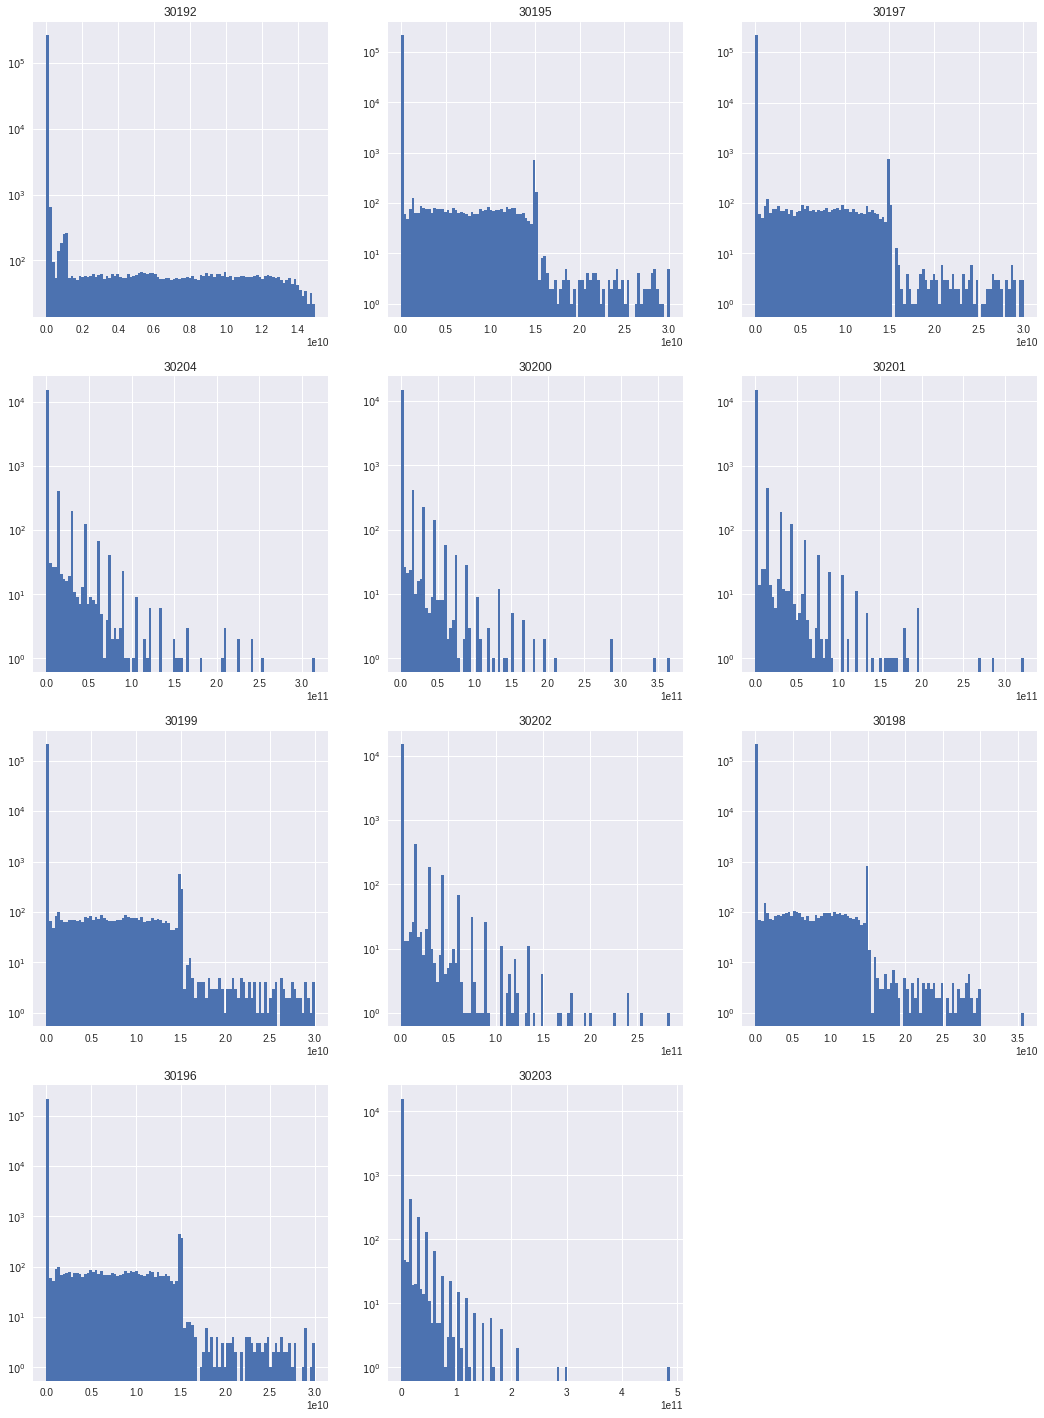

In [14]:
threads = set([log.thread for log in logs if log.thread > '30000'])

pyplot.figure(figsize=(18, 25))
for i, thread in enumerate(threads):
    pyplot.subplot((len(threads) + 2) // 3, 3, i + 1)
    pyplot.yscale('log')
    pyplot.title(thread)
    pyplot.hist((numpy.diff(df.query("thread == '" + thread + "'").date.as_matrix().astype(int))), bins=100)

In [86]:
for line in df.query('error_contains == True and suspicious_level == "Good" and msg_type != "qemuMonitorIOProcess"').msg:
    print(line)
    break